# Experiment: California Housing Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

from sklearn.datasets import fetch_california_housing  

housing = fetch_california_housing() 
x = housing.data
y = housing.target.reshape(-1,1)
x=preprocessing.StandardScaler().fit(x).transform(x) #normalize
x=pd.DataFrame(x)
y=pd.DataFrame(y)
data=pd.concat([y,x],axis=1)
train,test=train_test_split(data,test_size=0.3, random_state=1)

train_y = train.iloc[:,0]
train_x = train.iloc[:,1:]
test_y = test.iloc[:,0]
test_x = test.iloc[:,1:]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_x

,0,1,2,3,4,5,6,7
0,-0.503149,-1.083767,-0.462001,0.018689,1.535208,-0.036385,-0.689106,0.648722
1,-0.364659,0.982143,-0.418034,-0.088311,0.205330,0.054431,-0.857653,0.653714
2,-0.715648,1.617807,-0.219152,-0.279204,-0.119633,-0.035265,0.523497,-0.089991
3,-0.700173,-1.083767,0.410511,0.687172,1.008909,-0.065649,-0.735924,1.502236
4,0.333002,-1.719432,-0.055459,0.009491,0.276858,-0.050146,0.762273,-1.128183
...,...,...,...,...,...,...,...,...
14443,-1.099272,-0.924851,-0.555332,-0.020087,-0.305957,-0.057375,-0.876380,0.843383
14444,2.468780,1.061601,0.549474,-0.179651,-0.593833,-0.016802,-0.567377,-0.030095
14445,-1.441260,1.061601,-0.217538,-0.189596,-0.574406,-0.040979,-0.796789,0.653714
14446,-0.651904,-1.481058,-0.176785,-0.305747,-0.090492,-0.028604,-0.890426,1.202758


In [2]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [130]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 5e-4}],lr=5e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.5,last_epoch=300) 
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(500): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    scheduler.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>50 and float(test_loss)>max(dnn_testloss[-50:-1]):
        break
    
    if epoch % 10 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 14.096611022949219
            Test  set - loss: 0.6995125412940979
            
epoch 10
            Train set - loss: 0.4128504693508148
            Test  set - loss: 0.4473537802696228
            
epoch 20
            Train set - loss: 0.32872501015663147
            Test  set - loss: 0.42410022020339966
            
epoch 30
            Train set - loss: 0.6147395968437195
            Test  set - loss: 0.4103561043739319
            
epoch 40
            Train set - loss: 0.2830987870693207
            Test  set - loss: 0.38816186785697937
            
epoch 50
            Train set - loss: 0.35466766357421875
            Test  set - loss: 0.37112322449684143
            
epoch 60
            Train set - loss: 0.24381917715072632
            Test  set - loss: 0.38

In [133]:
#predict
x0=torch.from_numpy(test_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2.6611528 0.7628807 2.4197874 ... 1.579648  1.411746  1.9770093]
[3.55  0.707 2.294 ... 1.098 1.625 1.667]


In [ ]:
#predict
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.pinv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1))*np.sqrt(dnn_testloss[-1]))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))*np.sqrt(dnn_testloss[-1])<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))*np.sqrt(dnn_testloss[-1])>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 14448/14448 [01:20<00:00, 180.58it/s]


torch.Size([14448, 561])


100%|██████████| 6192/6192 [00:04<00:00, 1454.91it/s]

n-p: 13887  mark: 6192
length 2.284675678485441
95 coverage 0.9326550387596899


In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    dnn_testloss=[]
    t0=time.time()
    for epoch in range(500): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>50 and float(test_loss)>max(dnn_testloss[-50:-1]):
            break
        dnn_testloss.append(float(test_loss))
    
    x0=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
dnn_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",dnn_length)

cover=0
for i in range(len(test_y)):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
dnn_coverage=cover/len(test_y)
print("95 coverage",dnn_coverage)

## 2. Resnet

In [141]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(8,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 5e-4}],lr=5e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.5,last_epoch=300) 
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(500):
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    scheduler.step()
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>50 and float(test_loss)>max(res_testloss[-50:-1]):
        break
    
    if epoch % 10 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=8, out_features=32, bias=True)
    (fc2): Linear(in_features=8, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.5712760090827942
            Test  set - loss: 0.5936006307601929
            
epoch 10
            Train set - loss: 0.31345823407173157
            Test  set - loss: 0.4415057599544525
            
epoch 20
            Train set - loss: 0.3499375879764557
            Test  set - loss: 0.4140929877758026
            
epoch 30
            Train set - loss: 0.9471092224121094
            Test  set - loss: 0.40349408984184265
            
epoch 40
            Train set - loss: 0.38021886348724365
            Test  set - loss: 0.36472147703170776
            
epoch 50
            

In [142]:
#predict
x0=torch.from_numpy(test_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2.837086   0.72108847 2.2756755  ... 1.426889   1.3431073  2.0315123 ]
[3.55  0.707 2.294 ... 1.098 1.625 1.667]


In [144]:
#predict
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.pinv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1))*np.sqrt(res_testloss[-1]))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))*np.sqrt(res_testloss[-1])<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))*np.sqrt(res_testloss[-1])>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 14448/14448 [02:36<00:00, 92.34it/s]


torch.Size([14448, 1113])


100%|██████████| 6192/6192 [00:09<00:00, 647.57it/s]

n-p: 13335  mark: 6192
length 2.1347017366069867
95 coverage 0.9297480620155039


In [ ]:
#bootstrap  
boottime=40
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    t0=time.time()
    for epoch in range(1000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,38]-bootbase)
upper=bootbase-(sorted_bootlist[:,1]-bootbase)
print("confidence interval length",sorted_bootlist[:,38]-sorted_bootlist[:,1])
resnet_length=(sorted_bootlist[:,38]-sorted_bootlist[:,1]).mean()
print("average confidence interval length",resnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
resnet_coverage=cover/300
print("95 coverage",resnet_coverage)

## Random Feature

definition of random feature

In [3]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

## 3. multilayer learning

In [40]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(8,32,kernel='C',gamma=0.05)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.5)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 8e-4}],lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.5,last_epoch=300) 
loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(500): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    scheduler.step()
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>50 and float(test_loss)>max(kernelnn_testloss[-50:-1]):
        break
    
    
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
   
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1.4978989362716675
            Test  set - loss: 1.095447063446045
            
epoch 10
            Train set - loss: 0.6086536049842834
            Test  set - loss: 0.5219694375991821
            
epoch 20
            Train set - loss: 0.5379151105880737
            Test  set - loss: 0.42924004793167114
            
epoch 30
            Train set - loss: 0.5334770083427429
            Test  set - loss: 0.43925243616104126
            
epoch 40
            Train set - loss: 0.5941340923309326
            Test  set - loss: 0.43043848872184753
            
epoch 50
            Train set - loss: 0.3881561756134033
            Test  set - loss: 0.40446069836616516
            
epoch 60
            Train set - loss: 0.5897378921508789
            Test  set - loss: 0.40845829248428345
            
epoch 70
            Train 

In [146]:
#predict
x0=torch.from_numpy(test_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2.2276626 0.6898064 2.9766827 ... 1.7477827 1.5312881 1.512641 ]
[3.55  0.707 2.294 ... 1.098 1.625 1.667]


In [44]:
#predict
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.inv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_testloss[-1]))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_testloss[-1])<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_testloss[-1])>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

  0%|          | 0/14448 [00:00<?, ?it/s]

100%|██████████| 14448/14448 [00:43<00:00, 335.55it/s]


torch.Size([14448, 273])


100%|██████████| 6192/6192 [00:04<00:00, 1488.17it/s]

n-p: 14175  mark: 5307
length 2.429289396476004
95 coverage 0.9329187865083851


In [12]:
#penalty
#predict
wei=1e-4
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)


temp2=torch.linalg.inv(Fi.T @ Fi+wei *np.eye(Fi.T.shape[0]))
temp2=temp2.float()
temp=temp2@Fi.T @ Fi@temp2
p=Fi @temp2 @Fi.T
aa=len(train_x)-np.trace(2*p-p@p)
print(aa)
corr=(len(train_x)-f0.shape[0])/aa

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1])*corr
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 14448/14448 [00:42<00:00, 342.34it/s]


torch.Size([14448, 273])
14392.354873657227


100%|██████████| 6192/6192 [00:03<00:00, 1751.94it/s]

n-p: 14175  mark: 5016
length 2.423034092290774
95 coverage 0.9290271132376395


In [47]:
##conformal prediction
#predict
par=optimizer.param_groups[0]['params']
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(kernelnn_trainloss[-1])/np.sqrt(fFFf+1)])
    if fFFf < 0:
        continue
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]


mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 14448/14448 [00:10<00:00, 1325.32it/s]


13727.0


100%|██████████| 6192/6192 [00:03<00:00, 1568.44it/s]

length 2.7081802632145138
95 coverage 0.948545867493218


In [ ]:
##conformal prediction
#predict
x0=torch.from_numpy(train_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-train_y[:].to_numpy())
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
for i in range(len(test_x)):
    if pred.detach().numpy()[0][0]-a<test_y[i] and pred.detach().numpy()[0][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)


13727.0
length tensor(2.7090, dtype=torch.float64)
95 coverage 0.8325258397932817


In [ ]:
#bootstrap  
boottime=40
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 8e-4}],lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.5,last_epoch=300) 
    kernelnn_testloss=[]
    t0 = time.time()
    for epoch in range(500): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            loss.append(train_loss)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()
        scheduler.step()
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>50 and float(test_loss)>max(kernelnn_testloss[-50:-1]):
            break
        kernelnn_testloss.append(float(test_loss))
            
    x0=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,38]-bootbase)
upper=bootbase-(sorted_bootlist[:,1]-bootbase)
print("confidence interval length",sorted_bootlist[:,38]-sorted_bootlist[:,1])
kernelnet_length=(sorted_bootlist[:,38]-sorted_bootlist[:,1]).mean()
print("average confidence interval length",kernelnet_length)

cover=0
for i in range(len(test_y)):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
kernelnet_coverage=cover/len(test_y)
print("95 coverage",kernelnet_coverage)

## 4. Residual multilayer learning

In [48]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(8,32,kernel='C',gamma=0.05)
rff1=RandomFourierFeature(16,16,kernel='G',gamma=0.5)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=5)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,16,rff1)
        self.rblock2 = ResidualBlock(16,8,rff2)
        self.fc3 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 5e-5}],lr=5e-5,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.5,last_epoch=300) 
#lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.2) 
#lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.5)
#lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 
#lr_scheduler.LinearLR(optimizer,start_factor=1,end_factor=0.1,total_iters=80)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(500): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    scheduler.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>50 and float(test_loss)>max(reskernel_testloss[-50:-1]):
        break
    
    
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=16, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=16, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1.9875150918960571
            Test  set - loss: 1.7305762767791748
            
epoch 10
            Train set - loss: 0.6728225350379944
            Test  set - loss: 0.6793957352638245
            
epoch 20
            Train set - loss: 0.43957456946372986
            Test  set - loss: 0.5209282040596008
            
epoch 30
            Train set - loss: 0.35910627245903015
            Test  set - loss: 0.4722719192504883
            
epoch 40
            Train set - loss: 0.5696430802345276
            Test  set - loss: 0.44260352849960327
            
epoch 50
      

In [28]:
#predict
x0=torch.from_numpy(test_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2.9203224  0.84465724 2.1325233  ... 1.6935554  1.5784271  1.789282  ]
[3.55  0.707 2.294 ... 1.098 1.625 1.667]


In [29]:
#predict
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.pinv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_testloss[-1]))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_testloss[-1])<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_testloss[-1])>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 14448/14448 [01:57<00:00, 122.62it/s]


torch.Size([14448, 1017])


100%|██████████| 6192/6192 [00:08<00:00, 718.89it/s]

n-p: 13431  mark: 6192
length 2.2093999086112652
95 coverage 0.9231266149870802


In [ ]:
#penalty
#predict
wei=1e-4
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)


temp2=torch.linalg.inv(Fi.T @ Fi+wei *np.eye(Fi.T.shape[0]))
temp2=temp2.float()
temp=temp2@Fi.T @ Fi@temp2
p=Fi @temp2 @Fi.T
aa=len(train_x)-np.trace(2*p-p@p)
print(aa)
corr=(len(train_x)-f0.shape[0])/aa

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_trainloss[-1])*corr
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

In [51]:
##conformal prediction
#predict
par=optimizer.param_groups[0]['params']
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(reskernel_trainloss[-1])/np.sqrt(fFFf+1)])
    if fFFf < 0:
        continue
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]



mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

  0%|          | 0/14448 [00:00<?, ?it/s]

100%|██████████| 14448/14448 [00:22<00:00, 644.93it/s]


13727.0


100%|██████████| 6192/6192 [00:09<00:00, 672.20it/s]

length 2.6746361910695677
95 coverage 0.9525525116235843


In [52]:
##conformal prediction
#predict
x0=torch.from_numpy(train_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-train_y[:].to_numpy())
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
for i in range(len(test_x)):
    if pred.detach().numpy()[0][0]-a<test_y[i] and pred.detach().numpy()[0][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)


13727.0
length tensor(2.6700, dtype=torch.float64)
95 coverage 0.8170219638242894


In [ ]:
#bootstrap  
boottime=40
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-5,momentum=0.9) #optim.Adam(...)
    reskernel_testloss=[]
    t0 = time.time()
    for epoch in range(500): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            loss.append(train_loss)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>50 and float(test_loss)>max(reskernel_testloss[-50:-1]):
            break
        reskernel_testloss.append(float(test_loss))
            
    x0=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,38]-bootbase)
upper=bootbase-(sorted_bootlist[:,1]-bootbase)
print("confidence interval length",sorted_bootlist[:,38]-sorted_bootlist[:,1])
reskernelnet_length=(sorted_bootlist[:,38]-sorted_bootlist[:,1]).mean()
print("average confidence interval length",reskernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
reskernelnet_coverage=cover/300
print("95 coverage",reskernelnet_coverage)

In [ ]:
length=[dnn_length,resnet_length,kernelnet_length,reskernelnet_length]
coverage=[10*dnn_coverage,10*resnet_coverage,10*kernelnet_coverage,10*reskernelnet_coverage]
name=['dnn','resnet','mulyi-kernel','res-kernel']
print(length,coverage)
plt.bar(name,length)
plt.bar(name,coverage)
plt.legend(['length','coverage(10%)'])
plt.title("95% confidence interval")
plt.show()

comparison

In [35]:
def plot_choose(fig,start,data):
    fig.plot(np.arange(start,len(data)),data[start:])

DNN vs multilayer kernel

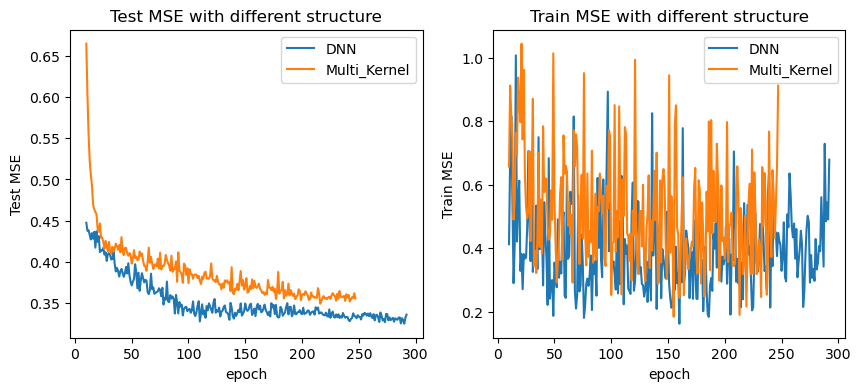

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],10,dnn_testloss)
plot_choose(ax[0],10,kernelnn_testloss)
ax[0].legend(["DNN","Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],10,dnn_trainloss)
plot_choose(ax[1],10,kernelnn_trainloss)
ax[1].legend(["DNN","Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

Resnet vs multilayer residual kernel

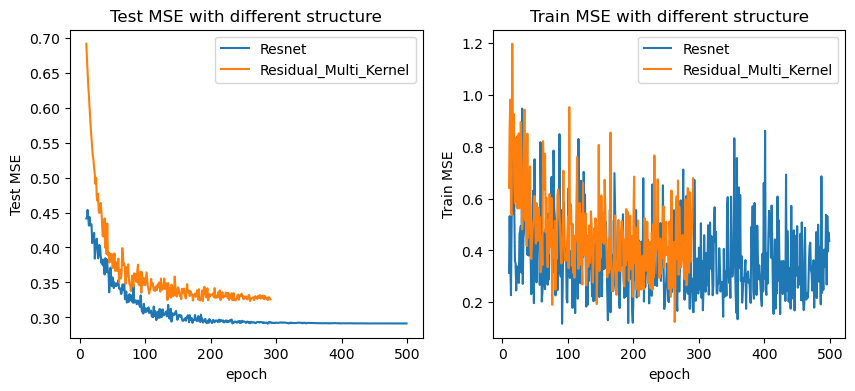

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],10,res_testloss)
plot_choose(ax[0],10,reskernel_testloss)
ax[0].legend(["Resnet","Residual_Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],10,res_trainloss)
plot_choose(ax[1],10,reskernel_trainloss)
ax[1].legend(["Resnet","Residual_Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

## data splitting

In [12]:
#multi
split=2
layer=2
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(8,32,kernel='C',gamma=0.05)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.5)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)
        
train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
schedulerset=[]
train_loss=[]
test_loss=[]

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset1=[]
for l in range(layer): #split into different dataset
    curx=train_x.values[row_rand_array[l*length:(l+1)*length]]
    cury=train_y.values[row_rand_array[l*length:(l+1)*length]]
    nnx = torch.from_numpy(curx).float()
    nny = torch.squeeze(torch.from_numpy(cury).float()) 
    train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
    train_loaderset1.append(train_loader)
    
for i in range(split):
    train_loaderset1=train_loaderset1[1:]+train_loaderset1[0:1]
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    scheduler1=[]
    optimizer1.append(optim.SGD([{'params': net.fc1.parameters(), 'initial_lr': 1e-2}],lr=1e-2,momentum=0.9,weight_decay=1e-4) )
    scheduler1.append(torch.optim.lr_scheduler.StepLR(optimizer1[-1],step_size=50,gamma=0.5,last_epoch=300))
    optimizer1.append(optim.SGD([{'params': net.fc2.parameters(), 'initial_lr': 1e-2}],lr=1e-2,momentum=0.9,weight_decay=1e-4) )
    scheduler1.append(torch.optim.lr_scheduler.StepLR(optimizer1[-1],step_size=50,gamma=0.5,last_epoch=300))
    optimizerset.append(optimizer1)
    schedulerset.append(scheduler1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
splkernel_trainloss=[]
splkernel_testloss=[]
t0 = time.time()
for epoch in range(500): 
    for i in range(split):
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            schedulerset[i][l].step() 
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        for i in range(split):
            y_test_pred = netset[i](x)
            y_test_pred = torch.squeeze(y_test_pred)
            
            test_loss[i] = criterion(y_test_pred,y)
    
    if epoch>50 and float(sum(test_loss)/len(test_loss))>max(splkernel_testloss[-50:-1]):
        break
    
    if epoch % 10 == 0: 
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splkernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splkernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("KernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 1.3322662115097046
            Test  set - loss: 1.1104230880737305
            
epoch 10
            Train set - loss: 0.5681198835372925
            Test  set - loss: 0.3880576193332672
            
epoch 20
            Train set - loss: 0.5514938235282898
            Test  set - loss: 0.3188088536262512
            
epoch 30
            Train set - loss: 0.9353998303413391
            Test  set - loss: 0.2870241105556488
            
epoch 40
            Train set - loss: 0.24756436049938202
            Test  set - loss: 0.2819342017173767
            
epoch 50
            Train set - loss: 0.39571407437324524
            Test  set - loss: 0.2823653221130371
            
epoch 60
            Train set - loss: 0.7356196641921997
            Test  set - loss: 0.28667202591896057
            
epoch 70
            Train set - loss: 0.5852091312408447
            Test  set - loss: 0.2870965301990509
            
epoch 80
            Train set - loss:

In [22]:
#res
split=3
layer=3
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(8,32,kernel='C',gamma=0.05)
rff1=RandomFourierFeature(16,16,kernel='G',gamma=0.5)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=5)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,16,rff1)
        self.rblock2 = ResidualBlock(16,8,rff2)
        self.fc3 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)
        
train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
schedulerset=[]
train_loss=[]
test_loss=[]

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset1=[]
for l in range(layer): #split into different dataset
    curx=train_x.values[row_rand_array[l*length:(l+1)*length]]
    cury=train_y.values[row_rand_array[l*length:(l+1)*length]]
    nnx = torch.from_numpy(curx).float()
    nny = torch.squeeze(torch.from_numpy(cury).float()) 
    train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
    train_loaderset1.append(train_loader)
    
for i in range(split):
    train_loaderset1=train_loaderset1[1:]+train_loaderset1[0:1]
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    scheduler1=[]
    
    optimizer1.append(optim.SGD([{'params': net.rblock1.parameters(), 'initial_lr': 1e-4}],lr=1e-4,momentum=0.9,weight_decay=1e-4) )
    scheduler1.append(torch.optim.lr_scheduler.StepLR(optimizer1[-1],step_size=50,gamma=0.5,last_epoch=300))
    optimizer1.append(optim.SGD([{'params': net.rblock2.parameters(), 'initial_lr': 1e-4}],lr=1e-4,momentum=0.9,weight_decay=1e-4) )
    scheduler1.append(torch.optim.lr_scheduler.StepLR(optimizer1[-1],step_size=50,gamma=0.5,last_epoch=300))
    optimizer1.append(optim.SGD([{'params': net.fc3.parameters(), 'initial_lr': 1e-4}],lr=1e-4,momentum=0.9,weight_decay=1e-4) )
    scheduler1.append(torch.optim.lr_scheduler.StepLR(optimizer1[-1],step_size=50,gamma=0.5,last_epoch=300))
    optimizerset.append(optimizer1)
    schedulerset.append(scheduler1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
splreskernel_trainloss=[]
splreskernel_testloss=[]
t0 = time.time()
for epoch in range(500): 
    for i in range(split):
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        for i in range(split):
            y_test_pred = netset[i](x)
            y_test_pred = torch.squeeze(y_test_pred)
            
            test_loss[i] = criterion(y_test_pred,y)
    
    if epoch>50 and float(sum(test_loss)/len(test_loss))>max(splreskernel_testloss[-50:-1]):
        break
    
    if epoch % 10 == 0: 
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splreskernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splreskernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("ResKernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 5.28722620010376
            Test  set - loss: 4.316873550415039
            
epoch 10
            Train set - loss: 1.0965628623962402
            Test  set - loss: 0.9847220778465271
            
epoch 20
            Train set - loss: 0.7840766906738281
            Test  set - loss: 0.578799307346344
            
epoch 30
            Train set - loss: 0.45922183990478516
            Test  set - loss: 0.49003687500953674
            
epoch 40
            Train set - loss: 0.5108558535575867
            Test  set - loss: 0.4245920479297638
            
epoch 50
            Train set - loss: 0.46089205145835876
            Test  set - loss: 0.41485270857810974
            
epoch 60
            Train set - loss: 0.6081504225730896
            Test  set - loss: 0.38870230317115784
            
epoch 70
            Train set - loss: 0.7816342711448669
            Test  set - loss: 0.37151291966438293
            
epoch 80
            Train set - loss: 